# Preparation

In [1]:
%matplotlib notebook
# imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle 
import numpy as np
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.utils.geometry_utils import transform_matrix
from pyquaternion import Quaternion

from IPython.display import HTML

# matplotlib.use('TkAgg')

In [2]:

# basic config and variables
_VERSION = 'v1.0-mini'
_DATAROOT = '/home/valerius/projects/praktikum-datafusion/data'

nusc = NuScenes(version=_VERSION, dataroot=_DATAROOT, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.279 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
def get_pcd_data(nusc_filepath: str):
    radar_point_cloud = RadarPointCloud.from_file(nusc_filepath)
    points =  radar_point_cloud.points
    x = points[0]
    y = points[1]
    vx_comp = points[8]
    vy_comp = points[9]

    return {
        'file': nusc_filepath,
        'x': x,
        'y': y,
        'vx_comp': vx_comp,
        'vy_comp': vy_comp,
        'v_comp': (vx_comp ** 2 + vy_comp ** 2) ** 0.5,
        'radar_point_cloud': radar_point_cloud
    }

def extract_channel_from_file(channel: str):
    filename = nusc.get('sample_data', channel)['filename']
    filename = f'{_DATAROOT}/{filename}'
    return get_pcd_data(filename)


def extract_samples_from_scene(scene: dict):
    """extract all the samples related to the given scene."""
    first_sample_token = scene['first_sample_token']
    last_sample_token = scene['last_sample_token']
    samples = list()

    fst = nusc.get('sample', first_sample_token)
    next_token = fst['next']
    while True:
        current = nusc.get('sample', next_token)
        samples.append(current)
        next_token = current['next']
        if next_token == last_sample_token:
            return samples


def convert_binary_data_to_coordinates_and_velocity(sample: dict):
    data = sample['data']
    return {
     'RADAR_FRONT' : extract_channel_from_file(data['RADAR_FRONT']),
     'RADAR_FRONT_LEFT' : extract_channel_from_file(data['RADAR_FRONT_LEFT']),
     'RADAR_FRONT_RIGHT' : extract_channel_from_file(data['RADAR_FRONT_RIGHT']),
     'RADAR_BACK_LEFT' : extract_channel_from_file(data['RADAR_BACK_LEFT']),
     'RADAR_BACK_RIGHT' : extract_channel_from_file(data['RADAR_BACK_RIGHT']),
     'data': data
    }

sc = nusc.scene[0]
samples_from_scene = extract_samples_from_scene(sc)
scene_in_sample_data = [convert_binary_data_to_coordinates_and_velocity(sc) for sc in samples_from_scene]


# 2 A Extracting Data

In [4]:
def load_files():
    """makes a biggo matrix containing all infos about 2 a)."""
    channels = [
        'RADAR_FRONT',
        'RADAR_FRONT_LEFT',
        'RADAR_FRONT_RIGHT',
        'RADAR_BACK_LEFT',
        'RADAR_BACK_RIGHT',
    ]
    samples = scene_in_sample_data
    scene_points = list()
    for sample in samples:
        x, y, z, vx_comp, vy_comp, pointclouds = list(), list(), list() ,list() ,list(), list()
        ego_pose_coords = []
        for channel in channels:
            pc = sample[channel]['radar_point_cloud']
            radar_token = sample['data'][channel]
            current_radar = nusc.get('sample_data', radar_token)
            ego_pose = nusc.get('ego_pose', current_radar['ego_pose_token'])
            calibrated_sensor = nusc.get('calibrated_sensor', current_radar['calibrated_sensor_token'])
            sensor_to_car = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation'], inverse=False))
            car_to_world = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation'], inverse=False))

            sensor_to_world = np.dot(car_to_world, sensor_to_car)

            pc.transform(sensor_to_world)

            pointclouds.append(pc)
            
            ego_pose_coords = ego_pose['translation']

            # combine radar
            
            for i in range(pc.points.shape[1]):
                x.append(pc.points[0][i])
                y.append(pc.points[1][i])
                z.append(pc.points[2][i]) # redundant?
                vx_comp.append(pc.points[8][i]) # 
                vy_comp.append(pc.points[9][i])
        scene_points.append([
            np.asarray(x),
            np.asarray(y),
            np.asarray(z),
            np.asarray(vx_comp),
            np.asarray(vy_comp),
            np.asarray(pointclouds),
            np.asarray(ego_pose_coords)
        ])

    return np.asarray(scene_points, dtype=object)


result = load_files()

# 2 B + D without Doppler velocities

In [5]:
plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)

def update(i):
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    x, y = row[0], row[1]
    vx, vy = row[3], row[4]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(900, 1300)
    plt.xlim(300, 550)


    plt.scatter(x, y, s=1)
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')

    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=len(result), interval=100)
# plt.show()

HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>

# 2 B + D Plotting Doppler velocities

In [7]:
plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)


def get_point_coords_from_v_comp(vx_comp, vy_comp, ego_x, ego_y, vehicle_x, vehicle_y):
    delta_x = vehicle_x - ego_x
    delta_y = vehicle_y - ego_y
    length_total = np.sqrt(delta_x**2 + delta_y**2)
    length_should = np.sqrt(vx_comp**2 + vy_comp**2)
    scalar = length_total / length_should
    return (ego_x, ego_y, delta_x/scalar, delta_y/scalar)
    

def update(i):
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    x, y = row[0], row[1]
    vx, vy = row[3], row[4]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]
    
    
    new_p = get_point_coords_from_v_comp(vx,vy,x, y, radar_ego_x, radar_ego_y)
    
    ego_x = new_p[0]
    ego_y = new_p[1]
    distance_x = new_p[2]
    distance_y = new_p[3]

    plt.cla()
    plt.ylim(900, 1300)
    plt.xlim(300, 550)


    plt.scatter(x, y, s=1, color='white')
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')
    
    for i in range(len(x)):
        plt.arrow(x[i], y[i], distance_x[i], distance_y[i], color="magenta")
    
    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=len(result), interval=100)
 #plt.show()

HTML(ani.to_html5_video())

In [8]:
# Extracting Annotation Tokens for the scene

scene_anns = [s['anns'] for s in samples_from_scene]

In [9]:
# Helper Class
class Vehicle:
    """
    Holding an annotated Vehicle
    """
    
    token = "None"
    x = None
    y = None
    w = None
    h = None
    angle = 0.0
    
    def __init__(self, annotation: dict):
        self.token = annotation['token']
        sample_translation = annotation['translation']
        self.x = sample_translation[0]
        self.y = sample_translation[1]
        sample_size = annotation['size']
        self.h = sample_size[1]
        self.w = sample_size[0]


    def get_left_corner(self):
        x_left = self.x - (self.w / 2)
        y_left = self.y - (self.h / 2)
        return (x_left, y_left)
    
    def get_trans(self):
        return (self.x, self.y)
    
    def __repr__(self):
        return f'TOKEN:{self.token}\tTRANSL:{self.get_trans()}\tLEFT_CORNER:{self.get_left_corner()}'


def get_vehicles_from_sample(ann_ids: [str]):
    """
    Extract vehicles from given sample with annotation ID.
    """
    anns = [nusc.get('sample_annotation', a_id) for a_id in ann_ids]
    anns = [v for v in anns if 'vehicle.' in v['category_name']]
    veh = [Vehicle(a) for a in anns]
    return veh

# get_vehicles_from_sample(scene_anns[0])

# 2 C + D Plotting bounding boxes

In [10]:
plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)

count = 0
last = None 


def update(i):
    global count
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    x, y = row[0], row[1]
    vx, vy = row[3], row[4]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(1000, 1300)
    plt.xlim(300, 500)
    vehicles = get_vehicles_from_sample(scene_anns[count])
    veh_coords = [v.get_trans() for v in vehicles]
    count += 1
    veh_coords_x = [x[0] for x in veh_coords]
    veh_coords_y = [x[1] for x in veh_coords]

    plt.scatter(x, y, s=1)
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')
    ego_w = 30
    ego_h = 20
    
    plt.gca().add_patch(Rectangle((radar_ego_x - 15, radar_ego_y - 10), 30, 20, color="white", fill=False))
    
    for i in range(len(veh_coords_y)):
        color = 'yellow'
        plt.gca().add_patch(Rectangle((veh_coords_x[i],veh_coords_y[i]), vehicles[i].w, vehicles[i].h, color=color, fill=False))
    
    plt.plot()

    


ani = animation.FuncAnimation(plt.gcf(), update, frames=len(result), interval=100)
plt.show()
HTML(ani.to_html5_video())

# 3 A

In [11]:
# Global constant
_SCENE_LENGTH = 37


def extract_sample_annotations_from_scene(scene: dict):
    """
    extract all the sample annotations related to the given scene.
    """
    first_sample_token = scene['first_sample_token']
    last_sample_token = scene['last_sample_token']
    
    sample_annotations = []
    
    fst = nusc.get('sample', first_sample_token)
    current = fst
    
    while True:
        [sample_annotations.append(a) for a in nusc.sample_annotation
            if a['sample_token'] == current['token'] and '' in a['category_name']]
        if current['token'] == last_sample_token:
            return sample_annotations
        current = nusc.get('sample', current['next'])

def walk_annotations(d, collector=[]):
    """
    recursivly get all annotations from sample.
    """
    if d['next'] == '':
        return collector
    collector.append(d)
    return walk_annotations(nusc.get('sample_annotation', d['next']), collector)

# Temporary collector
_data = dict()

for ann in extract_sample_annotations_from_scene(sc):
    global _data
    if ann['prev'] == '' and 'c3246a1e22a14fcb878aa61e69ae3329' in ann['attribute_tokens']:# and nusc.get('attribute', ann['attribute_tokens'][0])['name'] == 'vehicle.moving':
        _data[ann['token']] = len(walk_annotations(ann))

# Selecting a fitting annotation
#_data

In [12]:
# Vehicle to follow
last = nusc.get('sample_annotation', 'd02856dbe859476f9635f449d23aa211')

# Collector for annotations of selected vehicle
FOCUS = []

# extracting all annotation of that vehicle
while last['prev'] != '':
    FOCUS.append(last)
    last =  nusc.get('sample_annotation',last['prev'])

# Fabricate @Vehicle objects for the selected vehicle
FOCUS_VEHICLES = [Vehicle(nusc.get('sample_annotation', f['token'])) for f in FOCUS]

# FOCUS_VEHICLES

In [13]:
plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)

count = 0
last = None 


def update(i):
    global count
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    x, y = row[0], row[1]
    vx, vy = row[3], row[4]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(1000, 1300)
    plt.xlim(300, 500)
    vehicles = FOCUS_VEHICLES
    veh_coords = [v.get_trans() for v in vehicles]
    veh_coords_x = [x[0] for x in veh_coords]
    veh_coords_y = [x[1] for x in veh_coords]
    veh_coords_x.reverse()
    veh_coords_y.reverse()
    
    veh_coords_x = np.asarray(veh_coords_x)
    veh_coords_y = np.asarray(veh_coords_y)

    
    plt.scatter(x, y, s=1)
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')
    ego_w = 30
    ego_h = 20
    lens = 5.3 # Amplification of the bounding box to get all radar points
    i = count
    plt.gca().add_patch(Rectangle((veh_coords_x[i],veh_coords_y[i]), vehicles[i].w * lens, vehicles[i].h * lens, color='yellow', fill=False))
    plt.plot()

    count += 1


    


ani = animation.FuncAnimation(plt.gcf(), update, frames=len(result), interval=100)
# plt.show()
HTML(ani.to_html5_video())

# 3 B Filter the Pointclouds

In [14]:
# all radar points in box
plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)

count = 0
last = None 


def update(i):
    global count
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    x, y = row[0], row[1]
    vx, vy = row[3], row[4]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(1000, 1300)
    plt.xlim(300, 500)
    vehicles = FOCUS_VEHICLES
    veh_coords = [v.get_trans() for v in vehicles]
    veh_coords_x = [x[0] for x in veh_coords]
    veh_coords_y = [x[1] for x in veh_coords]
    veh_coords_x.reverse()
    veh_coords_y.reverse()
    
    veh_coords_x = np.asarray(veh_coords_x)
    veh_coords_y = np.asarray(veh_coords_y)

#     plt.scatter(veh_coords_x, veh_coords_y, s=20, color="white")
#     fig = plt.subplot()
    

    ego_w = 30
    ego_h = 20
    lens = 5.3
    current_x_min = veh_coords_x[count]
    current_y_min = veh_coords_y[count]
    width = vehicles[count].w * lens
    height = vehicles[count].h * lens
    plt.gca().add_patch(Rectangle((current_x_min,current_y_min), width, height, color='yellow', fill=False))
    count += 1
    coords, new_x, new_y = [],[],[]
    for p in list(zip(x,y)):
        is_in_x = current_x_min <= p[0] <= current_x_min + width
        is_in_y = current_y_min <= p[1] <= current_y_min + height
        if is_in_x and is_in_y:
            coords.append(p)
    
    new_x = [t[0] for t in coords]
    new_y = [t[1] for t in coords]
    plt.scatter(new_x, new_y, s=1)
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')
    plt.plot()

    


ani = animation.FuncAnimation(plt.gcf(), update, frames=len(result), interval=100)
# plt.show()
HTML(ani.to_html5_video())

# 3 C Average points

In [15]:
from statistics import mean
plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)

count = 0
last = None 


def update(i):
    global count
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    x, y = row[0], row[1]
    vx, vy = row[3], row[4]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(1000, 1300)
    plt.xlim(300, 500)
    vehicles = FOCUS_VEHICLES
    veh_coords = [v.get_trans() for v in vehicles]
    veh_coords_x = [x[0] for x in veh_coords]
    veh_coords_y = [x[1] for x in veh_coords]
    veh_coords_x.reverse()
    veh_coords_y.reverse()
    
    veh_coords_x = np.asarray(veh_coords_x)
    veh_coords_y = np.asarray(veh_coords_y)

    ego_w = 30
    ego_h = 20
    lens = 5.3
    current_x_min = veh_coords_x[count]
    current_y_min = veh_coords_y[count]
    width = vehicles[count].w * lens
    height = vehicles[count].h * lens
    plt.gca().add_patch(Rectangle((current_x_min,current_y_min), width, height, color='yellow', fill=False))
    count += 1
    coords, new_x, new_y = [],[],[]
    for p in list(zip(x,y)):
        is_in_x = current_x_min <= p[0] <= current_x_min + width
        is_in_y = current_y_min <= p[1] <= current_y_min + height
        if is_in_x and is_in_y:
            coords.append(p)
    
    new_x = ([t[0] for t in coords])
    new_y = ([t[1] for t in coords])
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')
    if new_x == [] or new_y == []:
            plt.plot()
            return
    new_x = sum(new_x) / len(new_x)
    new_y = sum(new_y) / len(new_y)
    plt.scatter(new_x, new_y, s=1)
    plt.plot()

    


ani = animation.FuncAnimation(plt.gcf(), update, frames=len(result), interval=100)
# plt.show()
HTML(ani.to_html5_video())

In [16]:
class Watcher:
    plt = None
    result = []
    xlim = (300, 500)
    ylim = (1000, 1300)
    ani = None
    
    
    
    def __init__(self, plt, result):
        self.plt = plt
        self.plt.style.use('dark_background')
        self.result = result
    
    
    def show(self):
        """
        Draws the animation
        """
        self.ani = animation.FuncAnimation(self.plt.gcf(), self.step, frames=len(self.result), interval=100)
        self.plt.show()
        return HTML(ani.to_html5_video())
    
    def step(self, frame):
        """
        stepper for the animation
        """
        
        row = self.result[frame]
        
        # extract values from row
        x, y = row[0], row[1]
        vx, vy = row[3], row[4]
        radar_ego_x = row[6][0]
        radar_ego_y = row[6][1]

        # clear plot + set limits
        self.plt.cla()
        self.plt.xlim(self.xlim[0], self.xlim[1])
        self.plt.ylim(self.ylim[0], self.ylim[1])
        
        # Get vehicle annotation from sample
        vehicles = get_vehicles_from_sample(scene_anns[frame])
        vehicle_coordinates = [v.get_trans() for v in vehicles]
        vehicle_x = [p[0] for p in vehicle_coordinates]
        vehicle_y = [p[1] for p in vehicle_coordinates]
        
        # draw radar points
        self.plt.scatter(x, y, s=1)
        
        # draw ego post
        self.plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')
        
        # draw vehicle annoations
        color = 'yellow'
        for i in range(len(vehicle_y)):
            self.plt.gca().add_patch(
                Rectangle(vehicle_coordinates[i], vehicles[i].w, vehicles[i].h, color=color, fill=False)
            )
        
        self.plt.plot()
        
        
w = Watcher(plt=plt, result=result)
w.show()

# 3 D - Add the Ground Truth to the graph

In [17]:
# average points
from statistics import mean
plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

avg_x = []
avg_y = []

result_iterator = iter(result)

count = 0
last = None 

coords_velocity = []

def update(i):
    global count
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    x, y = row[0], row[1]
    vx, vy = row[3], row[4]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(1000, 1300)
    plt.xlim(300, 500)
    vehicles = FOCUS_VEHICLES
    veh_coords = [v.get_trans() for v in vehicles]
    veh_coords_x = [x[0] for x in veh_coords]
    veh_coords_y = [x[1] for x in veh_coords]
    veh_coords_x.reverse()
    veh_coords_y.reverse()
    
    veh_coords_x = np.asarray(veh_coords_x)
    veh_coords_y = np.asarray(veh_coords_y)

#     plt.scatter(veh_coords_x, veh_coords_y, s=20, color="white")
#     fig = plt.subplot()
    

    ego_w = 30
    ego_h = 20
    lens = 5.3
    current_x_min = veh_coords_x[count]
    current_y_min = veh_coords_y[count]
    width = vehicles[count].w * lens
    height = vehicles[count].h * lens
    plt.gca().add_patch(Rectangle((current_x_min,current_y_min), width, height, color='yellow', fill=False))
    coords, new_x, new_y = [],[],[]
    for i, p in enumerate(list(zip(x,y))):
        is_in_x = current_x_min <= p[0] <= current_x_min + width
        is_in_y = current_y_min <= p[1] <= current_y_min + height
        if is_in_x and is_in_y:
            coords.append(p)
            current_data = {
                'x': x[i],
                'y': y[i],
                'vx': vx[i],
                'vy': vy[i],
                'row': count,
                'gt_x': veh_coords_x[count], 
                'gt_y': veh_coords_y[count]
            }
            coords_velocity.append(current_data)
    
    new_x = ([t[0] for t in coords])
    new_y = ([t[1] for t in coords])
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')
    plt.scatter(veh_coords_x[count], veh_coords_y[count], s=50, color='aquamarine')
#     if new_x == [] or new_y == []:
#             plt.plot()
#             return
    new_x = sum(new_x) / len(new_x)
    new_y = sum(new_y) / len(new_y)
    avg_x.append(new_x)
    avg_y.append(new_y)
    plt.scatter(new_x, new_y, s=20, color='#00ff00')
    plt.plot()
    count += 1

    


ani = animation.FuncAnimation(plt.gcf(), update, frames=37, interval=100)
# plt.show()
HTML(ani.to_html5_video())


# Excersise 4

## Initialise everything

In [35]:
#initial state -> x = [x, y, delta_x, delta_y]
#coords_velocity needed

x1 = coords_velocity[0]['x']
y1 = coords_velocity[0]['y']
x2 = coords_velocity[1]['x']
y2 = coords_velocity[1]['y']

x_init = [[x1], [y1], [x2 - x1], [y2 - y1]]

In [127]:
# init the "pick"-parameters

# initialise Cxx aka error covariance
Cxx_init = np.eye(4)

# initialise sigma
sigma = 1

# initialise Cvv aka R
R = np.eye(2)


In [20]:
# define / initialise Q aka process noise covariance aka Cww
q = np.array([[.125], [.125], [.5], [.5]])
Q = q @ ((sigma ** 2) * q.T)

# define / initialise F aka A aka T aka time update matrix
A = np.eye(4)
A[0][2] = 0.5
A[1][3] = 0.5

# define / initialise H aka the measurement matrix
H = np.eye(2,4)

## 4.a) TIME UPDATE FORMULAS :

In [21]:
# x_k+1 | k
def predict_state_x(x):
    x_predict = A @ x
    return x_predict

# TODO: sicher stellen dass wir alle scenes haben !!
#     -> falls nicht calc rauslassen, prediction kann bleiben

# test
x_predict1 = predict_state_x(x_init)
#x_predict1


# Cxx_k+1 | k
def predict_covariance_Cxx(current_Cxx):
    Cxx_predict = A @ current_Cxx @ A.T + Q
    return Cxx_predict

# test
Cxx_predict1 = predict_covariance_Cxx(Cxx_init)
Cxx_predict1

array([[1.265625, 0.015625, 0.5625  , 0.0625  ],
       [0.015625, 1.265625, 0.0625  , 0.5625  ],
       [0.5625  , 0.0625  , 1.25    , 0.25    ],
       [0.0625  , 0.5625  , 0.25    , 1.25    ]])

In [71]:
# calculate yk aka the measurements
def measurement_model_yk(x_current):
    y_k = H @ x_current
    return y_k

# test
yk1 = measurement_model_yk(x_init)
yk1, x_init

(array([[ 408.56102472],
        [1163.58531469]]),
 [[408.5610247173318],
  [1163.5853146936242],
  [-0.7670564000769673],
  [-0.3627294088225881]])

In [114]:
# calculate Kalman gain
def calc_kalman_gain(Cxx_predict):
    K_gain = Cxx_predict @ H.T @ np.linalg.inv(H @ Cxx_predict @ H.T + R)
    return K_gain
    
# test
K_gain1 = calc_kalman_gain(Cxx_predict1)
K_gain1

array([[0.5585997 , 0.00304414],
       [0.00304414, 0.5585997 ],
       [0.24809741, 0.02587519],
       [0.02587519, 0.24809741]])

## 4.b) MEASUREMENT UPDATES

In [115]:
# x_k+1
def measurement_update_x(x_predicted, y_k, K_gain):
    x_measurement = x_predicted + K_gain @ (y_k - H @ x_predicted)
    return x_measurement

# test
meas_x = measurement_update_x(x_predict1, yk1, K_gain1)
meas_x


# Cxx_k+1
def measurement_covariance_Cxx(Cxx_predicted, K_gain):
    Cxx_measurement = Cxx_predicted - K_gain @ H @ Cxx_predicted
    return Cxx_measurement

# test
meas_Cxx = measurement_covariance_Cxx(Cxx_predict1, K_gain1)
meas_Cxx

array([[0.5585997 , 0.00304414, 0.24809741, 0.02587519],
       [0.00304414, 0.5585997 , 0.02587519, 0.24809741],
       [0.24809741, 0.02587519, 1.10882801, 0.21993912],
       [0.02587519, 0.24809741, 0.21993912, 1.10882801]])

Function flow:

1. `x_init` -> `predict_state_x(x_init)`
2. init_Cxx -> predict_covariance_Cxx(init_Cxx)
3. K_gain_init -> calc_kalman_gain(2.)
4. x_init -> measurement_model_yk(x_init)

mesurement_upate_x(1., 4., 3.)
measurement_covariance_Cxx(2., 3.)

<Figure size 432x288 with 0 Axes>

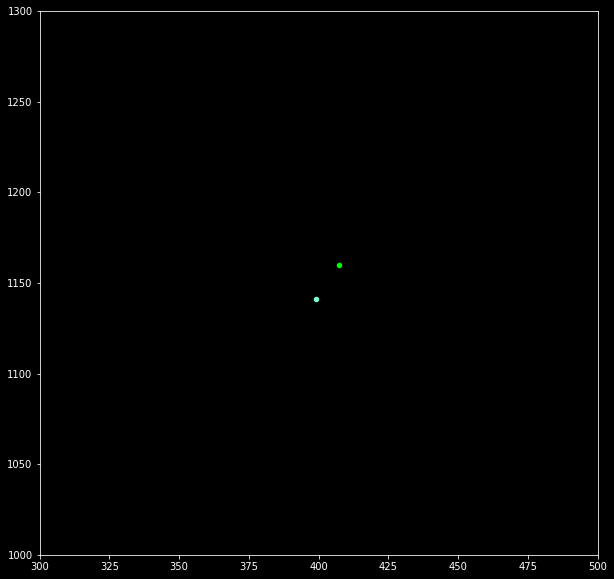

In [141]:
# plot prediction vs. actual state aka ground truth
# %matplotlib inline
plt.clf()
plt.figure(figsize=(10,10))
plt.style.use('dark_background')

x = list()
y = list()


result_iterator = iter(coords_velocity)

def reduce_messurement(row_index: int):
    """
    average all meassurements and return it with ground truth 
    """
    row = [e for e in coords_velocity if e['row'] == row_index]
    
    return {
        'x': mean([e['x'] for e in row]),
        'y': mean([e['y'] for e in row]),
        'vx': mean([e['vx'] for e in row]),
        'vy': mean([e['vy'] for e in row]),
        'gt_x': row[0]['gt_x'],
        'gt_y': row[0]['gt_y']
    }


def update_prediction_plot():
    c_meas = Cxx_init
    x_meas = x_init
    
    collector = []
    
    for i in range(37):
        # Time Update
        x_meas = predict_state_x(x_meas)
        cxx_prediction = predict_covariance_Cxx(c_meas)
        
        # -> prediction
        
        # Measurement Update <- Measurement
        rm = reduce_messurement(i)
        gt_x,gt_y = rm['x'], rm['y']
        
        K = calc_kalman_gain(cxx_prediction)
        y_k = measurement_model_yk(x_meas)
        x_meas = measurement_update_x(x_meas, np.array([[gt_x],[gt_y]]), K)
        c_meas = measurement_covariance_Cxx(cxx_prediction, K)
        
        collector.append([x_meas[0][0], x_meas[1][0]])
        

    return np.asarray(collector, dtype=float)

predictions = update_prediction_plot()

def update(frame):
    row = reduce_messurement(frame) 
    current_prediction = predictions[frame]
    
    rrow = result[frame]
    
    px = current_prediction[0]
    py = current_prediction[1]
    
    gt_x = row['gt_x']
    gt_y = row['gt_y']

    plt.cla()
    plt.ylim(1000, 1300)
    plt.xlim(300, 500)
    plt.scatter(gt_x, gt_y, s=20, color='aquamarine') # GTs
    plt.scatter(px, py, s=20, color='#00ff00') # predictions
#     plt.scatter(rrow[0][frame], rrow[1][frame], s=20, color="magenta")
    plt.plot()



ani = animation.FuncAnimation(plt.gcf(), update, frames=37, interval=100)
HTML(ani.to_html5_video())
# predictions

In [27]:
def v_length(vx, vy):
    return np.sqrt(vx ** 2 + vy ** 2)

v_ls = [
    v_length(v[0], v[1]) for v in zip(
        [e['vx'] for e in coords_velocity], 
        [e['vy'] for e in coords_velocity])
]

sigma = get_recursive_variance(np.array(v_ls))


NameError: name 'get_recursive_variance' is not defined

In [ ]:
from functools import reduce
# def time_update_mean(x: np.array):
#     T = np.eye(4)
#     T[0][2] = 0.5
#     T[1][3] = 0.5
#     w = np.array([x[2] / .5, x[3] / .5, 0, 0])
#     x_new = T @ x.T + w.T
#     return np.array(x_new)

# help(reduce)

def get_recursive_mean(arr: np.array):
    recursive_arr = []
    recursive_arr.append(arr[0])
    recursive_arr.append(arr[1])
    g_var = []
    var = np.mean(recursive_arr)
    g_var.append(var)
    
    for i in range(2, len(arr)):
        recursive_arr.append(arr[i])
        var = np.mean(recursive_arr)
        g_var.append(var)
    return np.asarray(g_var, dtype=float)

mean_x = get_recursive_mean([e['x'] for e in coords_velocity])
mean_vx = get_recursive_mean([e['vx'] for e in coords_velocity])
mean_y = get_recursive_mean([e['y'] for e in coords_velocity])
mean_vy = get_recursive_mean([e['vy'] for e in coords_velocity])

means = np.array([mean_x, mean_y, mean_vx, mean_vy])
means.shape

In [ ]:
T = np.eye(4)
T[0][2] = 0.5
T[1][3] = 0.5

estimate = []

for i in range(len(means[0])):
    v = np.array([means[0][i], means[1][i], means[2][i], means[3][i]])
    estimate.append(T @ v)

estimate = np.asarray(estimate, dtype=object)
estimate

In [ ]:
#TIME UPDATE STUFF
estimate
error_cov = T @ covariance_matrices @ T.T + np.array(pnc_matrices)
H = np.eye(2, 4)

x = np.array([e['x'] for e in coords_velocity])
y = np.array([e['y'] for e in coords_velocity])
vx = np.array([e['vx'] for e in coords_velocity])
vy = np.array([e['vy'] for e in coords_velocity])
x_k = np.array([
    x,
    y,
    vx,
    vy
]).T

y_k = np.array([(H @ x).T for x in x_k])

y_k[0]

In [ ]:
# K_gainz = error_cov @ H.T @ np.linalg.inv(H @ error_cov @ H.T + R)
# x_mes = estimate + K * (y - H @ estimate)

In [ ]:
#excercise 6

# v_ls needed from 4

alphas = list()
for i in range(len(v_ls)):
    a_curr = np.arccos(coords_velocity[i]['vx']/v_ls[i])
    alphas.append(a_curr)
    
alphas = np.array(alphas)  
# alphas

In [ ]:
x = np.array([e['x'] for e in coords_velocity])
y = np.array([e['y'] for e in coords_velocity])
state_x_ex6 = np.array([x, y, v_ls, alphas]).T

# state_x_ex6 = []

In [ ]:
#from sympy.matrices import jacobian
#y = yk ??
#TODO: a(x) berechnen - delta t = const 0.5?
#TODO: Jacobian A berechnen
#TODO: Jacobian H